In [ ]:
!rm -rf ./models

In [1]:
import os, glob
import pandas as pd
import IPython.display
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import random
import pandas as pd
import time
from datetime import datetime
import json

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)   
pd.set_option('display.width', None)          
pd.set_option('display.max_colwidth', None) 
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
if device.type == "cuda":
    device_name = torch.cuda.get_device_name(0)
    device_count = torch.cuda.device_count()
    device_properties = torch.cuda.get_device_properties(0)
    print("Device name: ", device_name)
    print("Device count: ", device_count)
    print("Device memory (GB): ", device_properties.total_memory / 1e9)

os.makedirs("models", exist_ok=True)

Using device:  cuda
Device name:  Tesla P100-PCIE-16GB
Device count:  1
Device memory (GB):  17.059545088


In [2]:
train_df = pd.read_csv("./Train.csv", index_col=0)

print(train_df.value_counts("Label"))
display(train_df)

Label
REAL    2615
FAKE    2448
Name: count, dtype: int64


,File Path,Label,Frame Count
0,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/wbpcawlkxt.mp4,REAL,148
1,/kaggle/input/celeb-df-face-only/CELEB_DF/Celeb_fake_face_only/id28_id38_0009.mp4,FAKE,148
2,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/tpzecuwvyf.mp4,REAL,148
3,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/wcqvzujamg.mp4,REAL,148
4,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_FAKE_Face_only/eaakpmkvvp.mp4,FAKE,148
...,...,...,...
5155,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/nyfqdjrcxr.mp4,REAL,148
5156,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_FAKE_Face_only/bljlskjwsg.mp4,FAKE,148
5157,/kaggle/input/ff-face-only/FF_Face_only_data/700_813.mp4,FAKE,148
5158,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/eynxajczkd.mp4,REAL,148


In [3]:
test_df = pd.read_csv("./Test.csv", index_col=0)

print(test_df.value_counts("Label"))
display(test_df)

Label
REAL    658
FAKE    607
Name: count, dtype: int64


,File Path,Label,Frame Count
0,/kaggle/input/ff-face-only/FF_Face_only_data/144_122.mp4,FAKE,148
2,/kaggle/input/ff-face-only/FF_Face_only_data/473_366.mp4,FAKE,148
3,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/apeftlgrqg.mp4,REAL,148
4,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_FAKE_Face_only/cttbiujgiv.mp4,FAKE,148
5,/kaggle/input/ff-face-only/FF_Face_only_data/133_148.mp4,FAKE,148
...,...,...,...
1286,/kaggle/input/ff-face-only/FF_Face_only_data/339.mp4,REAL,148
1287,/kaggle/input/ff-face-only/FF_Face_only_data/587.mp4,REAL,148
1288,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_REAL_Face_only/haqhhmprto.mp4,REAL,148
1289,/kaggle/input/dfdc-real-fake-face-only/DFDC_REAL_FAKE/DFDC_FAKE_Face_only/bfmvjimrqn.mp4,FAKE,148


In [4]:
class video_dataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        label = self.labels[idx]
        if label == 'FAKE':
            label = 0
        elif label == 'REAL':
            label = 1

        for frame in self.frame_extract(video_path):
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
            
        return frames, label
    
    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = True
        while success:
            success, image = vidObj.read()
            if success:
                yield image

In [6]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_videos = train_df["File Path"].tolist()
valid_videos = test_df["File Path"].tolist()

train_labels = train_df["Label"].tolist()
valid_labels = test_df["Label"].tolist()

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

train_data = video_dataset(train_videos, train_labels, sequence_length=120, transform=train_transforms)
val_data = video_dataset(valid_videos, valid_labels,sequence_length=120, transform=train_transforms)

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 0)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 0)

In [6]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in valid_loader: {len(valid_loader)}")

print(f"Batch size used: {train_loader.batch_size}")

for i, (inputs, targets) in enumerate(train_loader):
    if i == 0:  # Print the first batch only
        print(f"Shape of input in first batch: {inputs.shape}")
        print(f"Shape of target in first batch: {targets.shape}")
    break

for i, (inputs, targets) in enumerate(valid_loader):
    if i == 0:  # Print the first batch only
        print(f"Shape of input in first batch (validation): {inputs.shape}")
        print(f"Shape of target in first batch (validation): {targets.shape}")
    break

Number of batches in train_loader: 1266
Number of batches in valid_loader: 317
Batch size used: 4
Shape of input in first batch: torch.Size([4, 120, 3, 112, 112])
Shape of target in first batch: torch.Size([4])
Shape of input in first batch (validation): torch.Size([4, 120, 3, 112, 112])
Shape of target in first batch (validation): torch.Size([4])


In [7]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, gru_layers=2, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(weights='DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.gru = nn.GRU(latent_dim, hidden_dim,
                          gru_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_gru, _ = self.gru(x)

        return fmap, self.dp(self.linear1(torch.mean(x_gru, dim=1)))


if 'model' in globals():
    del model
model = Model(num_classes=2).cuda()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 179MB/s]


In [8]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    print(f"<========== Epoch [{epoch}/{num_epochs}] ==========>")
    losses = AverageMeter()
    accuracies = AverageMeter()
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch}/{num_epochs}] | Step [{i}/{len(data_loader)}] | Loss: {losses.avg:.4f} | Accuracy: {accuracies.avg:.2f}", end="\r", flush=True)

    return losses.avg, accuracies.avg


def test(epoch, model, data_loader, criterion, train_loss, train_acc):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _, outputs = model(inputs)
            loss = torch.mean(
                criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(
                outputs, targets.type(torch.cuda.LongTensor))
            _, p = torch.max(outputs, 1)
            true += (targets.type(torch.cuda.LongTensor)
                     ).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            print(
                f"Step [{i}/{len(data_loader)}] | Loss: {losses.avg:.4f} | Accuracy: {accuracies.avg:.2f}", flush=True, end="\r")

        test_acc = accuracies.avg
        test_loss = losses.avg
        print(
            f'\n Testing Accuracy for {epoch} : {test_acc}\n Testing Loss for {epoch} : {test_loss}')
        torch.save(model.state_dict(
        ), f'./models/DD_Torch_Model_epoch({epoch})_acc({train_acc})_loss({train_loss})_testacc({test_acc})_testloss({test_loss}).pt')
        print(f"<========== Completed [Epoch {epoch}] ==========>")
    return true, pred, test_loss, test_acc


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size

In [9]:
lr = 1e-5
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss().cuda()

train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs+1):
    start_time = datetime.now()
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader,
                                        model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    print()
    true, pred, test_loss, test_acc = test(
        epoch, model, valid_loader, criterion, train_loss, train_acc)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)
    
    end_time = datetime.now()
    time_difference = end_time - start_time
    total_seconds = int(time_difference.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    
    print(f"Time taken for epoch {epoch} - {hours:02}:{minutes:02}:{seconds:02}")
    print()

<========== Epoch [1/20] ==========>
Epoch [1/20] | Step [1265/1266] | Loss: 0.6729 | Accuracy: 57.61
Testing
Step [316/317] | Loss: 0.5173 | Accuracy: 75.49
 Testing Accuracy for 1 : 75.49407114624506
 Testing Loss for 1 : 0.5172939713764567
<========== Completed [Epoch 1] ==========>
Time taken for epoch 1 - 00:29:51

<========== Epoch [2/20] ==========>
Epoch [2/20] | Step [1265/1266] | Loss: 0.5485 | Accuracy: 75.57
Testing
Step [316/317] | Loss: 0.4072 | Accuracy: 83.16
 Testing Accuracy for 2 : 83.16205533596838
 Testing Loss for 2 : 0.40718100012055497
<========== Completed [Epoch 2] ==========>
Time taken for epoch 2 - 00:29:50

<========== Epoch [3/20] ==========>
Epoch [3/20] | Step [1265/1266] | Loss: 0.4723 | Accuracy: 81.18
Testing
Step [316/317] | Loss: 0.3203 | Accuracy: 87.43
 Testing Accuracy for 3 : 87.43083003952569
 Testing Loss for 3 : 0.3203111478079685
<========== Completed [Epoch 3] ==========>
Time taken for epoch 3 - 00:29:47

<========== Epoch [4/20] ========

KeyboardInterrupt: 

In [13]:
name = "DD_ALL_GRU_Torch"

In [10]:
history = {
    "accuracy": train_accuracy,
    "loss": train_loss_avg,
    "val_accuracy": test_accuracy,
    "val_loss": test_loss_avg
}

with open(f"{name}.json", "w") as f:
    json.dump(history, f)
print(f"Saved {name}.json")

Saved DD_ALL_GRU_Torch.json


In [10]:
with open("/kaggle/working/DD_ALL_GRU_Torch.json", "r") as f:
    dd_torch_history  = json.load(f)

In [11]:
from tabulate import tabulate

metrics = list(dd_torch_history.keys())
num_epochs = len(dd_torch_history[metrics[0]])

history_table = []
for epoch in range(num_epochs):
    row = [epoch + 1] + [dd_torch_history[metric][epoch] for metric in metrics]
    history_table.append(row)

print(tabulate(history_table, headers=["Epoch"] + metrics, tablefmt="grid"))

+---------+------------+----------+----------------+------------+
|   Epoch |   accuracy |     loss |   val_accuracy |   val_loss |
+=========+============+==========+================+============+
|       1 |    57.6141 | 0.672936 |        75.4941 |   0.517294 |
+---------+------------+----------+----------------+------------+
|       2 |    75.5678 | 0.54846  |        83.1621 |   0.407181 |
+---------+------------+----------+----------------+------------+
|       3 |    81.1772 | 0.472325 |        87.4308 |   0.320311 |
+---------+------------+----------+----------------+------------+
|       4 |    84.9891 | 0.403797 |        87.5889 |   0.297579 |
+---------+------------+----------+----------------+------------+
|       5 |    87.616  | 0.361847 |        87.2727 |   0.320933 |
+---------+------------+----------+----------------+------------+
|       6 |    89.7294 | 0.331364 |        89.0119 |   0.287696 |
+---------+------------+----------+----------------+------------+
|       7 

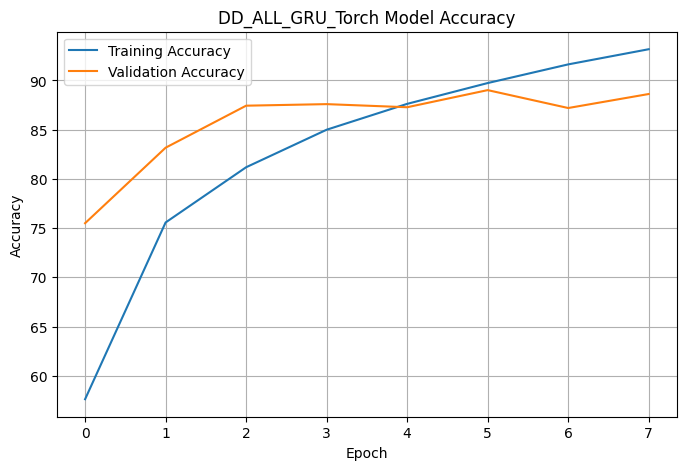

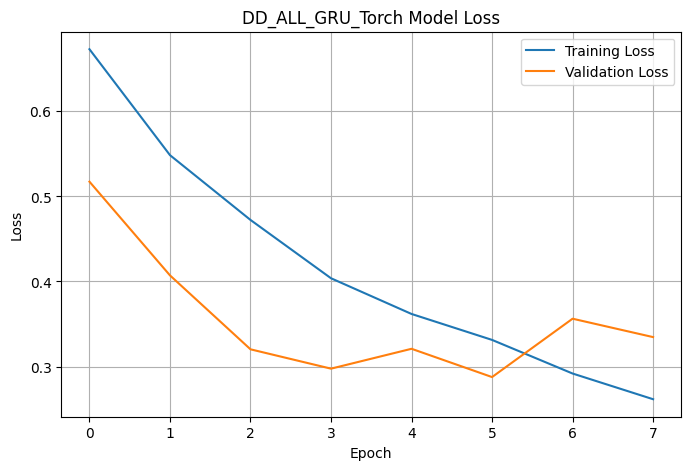

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(dd_torch_history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in dd_torch_history:
    plt.plot(dd_torch_history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{name} Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(dd_torch_history['loss'], label='Training Loss')
if 'val_loss' in dd_torch_history:
    plt.plot(dd_torch_history['val_loss'], label='Validation Loss')
plt.title(f'{name} Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [17]:
def conf_mat(model, data_loader, criterion):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _, outputs = model(inputs)
            loss = torch.mean(
                criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(
                outputs, targets.type(torch.cuda.LongTensor))
            _, p = torch.max(outputs, 1)
            true += (targets.type(torch.cuda.LongTensor)
                     ).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            print(
                f"Step [{i}/{len(data_loader)}] | Loss: {losses.avg:.4f} | Accuracy: {accuracies.avg:.2f}", flush=True, end="\r")

        test_acc = accuracies.avg
        test_loss = losses.avg
    return true, pred, test_loss, test_acc

In [24]:
model_path = '/kaggle/working/models/DD_Torch_Model_epoch(8)_acc(93.16610705115544)_loss(0.2616659907878248)_testacc(88.61660079051383)_testloss(0.3346584242670173).pt'

# Load the state dictionary
state_dict = torch.load(model_path, weights_only=True)

# Load the weights into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
criterion = nn.CrossEntropyLoss().cuda()

true, pred, test_loss, test_acc = conf_mat(model, valid_loader, criterion)

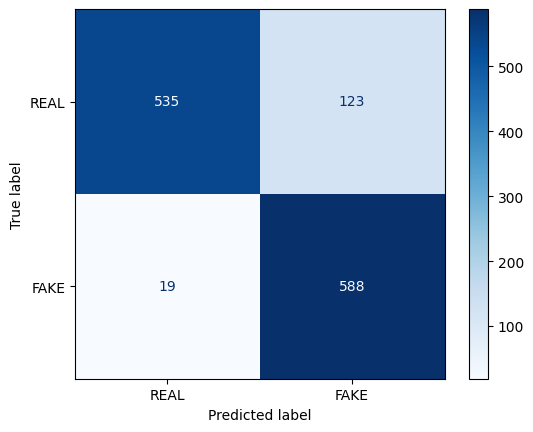

In [26]:
cm = confusion_matrix(true, pred, labels=[1, 0])  # Labels: 1 for REAL, 0 for FAKE

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap='Blues')
plt.show()

In [27]:
from sklearn.metrics import classification_report

report = classification_report(true, pred, target_names=["FAKE", "REAL"])
print(report)

              precision    recall  f1-score   support

        FAKE       0.83      0.97      0.89       607
        REAL       0.97      0.81      0.88       658

    accuracy                           0.89      1265
   macro avg       0.90      0.89      0.89      1265
weighted avg       0.90      0.89      0.89      1265

